# 循环神经网络的从零开始实现



In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
# 每次训练用32个独立序列
# 每个序列长度为35个时间步（预测35个字符）
batch_size, num_steps = 32, 35
'''
一键加载 ：调用封装函数，返回数据迭代器和词表**。
内部流程（自动化完成）：
1、下载并读取《时间机器》文本
2、字符级分词
3、构建词表（字符→索引映射）
4、创建SeqDataLoader迭代器
train_iter
类型：可迭代对象（生成器）。
功能：在训练循环中，每次迭代返回一个批次
vocab
类型：Vocab 词表实例。
功能：提供索引与字符的相互转换：
'''
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

独热编码

In [2]:
'''
1. torch.tensor([0, 2])输入索引：表示要编码的两个词元ID，索引0和索引2。
2. len(vocab)编码维度：词表总大小，决定独热向量的长度。
示例：若词表大小为28，则每个词元被编码为28维向量。
3. F.one_hot(...)PyTorch函数：F通常是torch.nn.functional的别名。功能：将索引张量转换为稀疏的独热表示。
'''
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

小批量数据形状是二维张量：
（批量大小，时间步数）

In [3]:
'''
torch.arange(10)：生成[0,1,2,3,4,5,6,7,8,9]
.reshape((2,5))：重塑为形状(2,5)的矩阵
维度含义：batch_size=2，num_steps=5（2个样本，每个5个时间步）
'''
X = torch.arange(10).reshape((2, 5))
'''
X.T（转置）操作：对X进行转置，交换维度0和1
目的：将时间步维度放在第一维，便于后续循环处理（如RNN按时间步迭代）。
F.one_hot(...,28)
独热编码：对 X.T 中的每个索引（最大值为9<28），生成28维的0-1向量。
输出结构：在最后一个维度添加类别维度。
'''
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

初始化循环神经网络模型的模型参数

In [4]:
def get_params(vocab_size, num_hiddens, device):
    # 确定维度：RNN的输入和输出维度都等于词表大小（因为每个时间步输入/输出都是一个词元）
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        '''
        目的：打破对称性，避免所有神经元学习到相同特征
        缩放因子 0.01：控制初始化幅值，防止梯度爆炸/消失
        生成正态分布随机数：从标准正态分布（均值=0，标准差=1）中采样。
        size=shape：指定输出张量的形状，如 (100, 50)。
        device=device：在指定设备（CPU/GPU）上创建张量。
        '''
        return torch.randn(size=shape, device=device) * 0.01
    '''
    输入→隐藏权重：形状(vocab_size,num_hiddens)
    作用：将输入词元（独热编码）映射到隐藏状态空间
    '''
    W_xh = normal((num_inputs, num_hiddens))
    '''
    隐藏→隐藏权重：形状(num_hiddens,num_hiddens)
    核心参数：实现循环连接，让当前隐藏状态能记住前一时刻的信息
    '''
    W_hh = normal((num_hiddens, num_hiddens))
    '''
    隐藏层偏置：全零向量，形状(num_hiddens)
    作用：为隐藏状态神经元提供可调偏移量
    '''
    b_h = torch.zeros(num_hiddens, device=device)
    '''
    隐藏→输出权重：形状 (num_hiddens,vocab_size)。
    作用：将隐藏状态转换回词表空间，用于预测下一个词元。
    '''
    W_hq = normal((num_hiddens, num_outputs))
    '''
    输出层偏置：全零向量，形状(vocab_size)。
    作用：为输出预测提供可调偏移量。
    '''
    b_q = torch.zeros(num_outputs, device=device)
    # 参数列表：将所有权重和偏置收集到一个列表中，便于统一管理
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    '''
    启用梯度追踪：对每个参数调用requires_grad_(True)
    关键作用：告诉PyTorch需要计算梯度以进行反向传播和参数更新
    _结尾的方法名：表示原地操作，直接修改张量属性
    '''
    for param in params:
        param.requires_grad_(True)
    return params

一个`init_rnn_state`函数在初始化时返回隐状态

In [5]:
def init_rnn_state(batch_size, num_hiddens, device):
    '''
    创建零张量：形状为 (批次大小, 隐藏层维度)，例如 (32, 256)。
    全零初始化：隐藏状态从零开始，表示模型在初始时刻没有"记忆"。
    device=device：确保状态张量与模型在同一设备（CPU/GPU）上。
    (..., )（返回元组）
    单元素元组：将零张量包装在元组中返回。
    关键设计：这样做的目的是为了接口统一：
    简单RNN：只有一个隐藏状态h，返回(h,)。
    LSTM：需要两个状态（隐藏状态h+细胞状态c），返回 (h,c)。
    统一调用：后续代码可以用state[0]访问隐藏状态，无需区分RNN类型。

    '''
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下面的`rnn`函数定义了如何在一个时间步内计算隐状态和输出

| 函数                 | 支持维度     | 广播 | 适用场景        |
| ------------------ | -------- | -- | ----------- |
| **`torch.mm`**     | **仅限2D** | ❌  | 严格矩阵乘法      |
| **`torch.matmul`** | 任意维度     | ✅  | 通用张量乘法，支持批量 |


In [6]:
'''
循环神经网络的前向计算。
inputs：输入序列（通常是形状为(num_steps,batch_size,vocab_size)的独热编码张量）
state：初始隐藏状态，格式为(H,)
params：模型参数列表[W_xh,W_hh,b_h,W_hq,b_q]
'''
def rnn(inputs, state, params):
    # 解包参数：将参数列表拆分为独立变量，便于后续使用
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 提取隐藏状态：从元组中取出隐藏状态张量H
    H, = state
    outputs = []
    #  按时间步循环：遍历每个时间步的输入X（形状为 (batch_size,vocab_size)）
    for X in inputs:
        '''
        核心更新公式：计算新的隐藏状态。
        torch.mm(X,W_xh)：输入到隐藏的线性变换
        torch.mm(H,W_hh)：循环连接的线性变换（记忆历史）
        +b_h：添加偏置
        torch.tanh(...)：用tanh激活函数引入非线性，控制数值范围
        '''
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 计算输出：将当前隐藏状态映射到输出空间，得到每个词元的原始得分（logits）
        Y = torch.mm(H, W_hq) + b_q
        # 收集输出：将每个时间步的输出添加到列表中
        outputs.append(Y)
    '''
    torch.cat(outputs,dim=0)：将所有时间步的输出拼接成一个大张量，形状为(num_steps*batch_size,vocab_size)
    (H,)：返回最终隐藏状态（包装为元组，保持接口一致性）
    '''
    return torch.cat(outputs, dim=0), (H,)

创建一个类来包装这些函数

In [7]:
class RNNModelScratch: 
    """从零开始实现的循环神经网络模型"""
    '''
    ocab_size：词表大小（输入/输出维度）
    num_hiddens：隐藏层维度
    device：计算设备（CPU/GPU）
    get_params, init_state, forward_fn：三个函数，实现依赖注入
    '''
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        # 策略模式：将具体实现推迟到运行时，支持灵活替换不同RNN结构（如LSTM）
        # 存储模型配置：将词表大小和隐藏层维度保存为实例属性。
        # 目的：后续前向传播中需要self.vocab_size进行独热编码，需要self.num_hiddens初始化状态。
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        '''
        初始化模型参数：调用get_params函数生成5个权重/偏置张量
        存储：将参数列表保存为self.params，供前向传播和优化器使用
        关键：参数在构造时创建，确保每个模型实例拥有独立的参数空间
        '''
        self.params = get_params(vocab_size, num_hiddens, device)
        '''
        存储函数引用：将状态初始化函数和前向计算函数作为属性绑定。
        设计模式：这是策略模式的应用，允许运行时动态切换不同RNN变体（如LSTM/GRU）。
        延迟执行：这些函数在调用时才执行（__call__和begin_state中）。

        '''
        self.init_state, self.forward_fn = init_state, forward_fn
    # 前向传播
    def __call__(self, X, state):
        '''
        X.T：转置输入，从(batch, time)变为(time,batch)，适配循环逻辑
        F.one_hot(...)：将索引转换为独热编码，形状 (time,batch,vocab_size)
        .type(torch.float32)：转换为浮点类型，满足矩阵乘法要求
        调用前向函数：self.forward_fn是之前定义的rnn函数，执行实际的循环计算。
        '''
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    '''
    batch_size：当前批次包含的序列数量（如32）
    device：计算设备（如'cuda'或'cpu'）
    执行逻辑
    调用绑定函数：执行构造时传入的self.init_state函数（即init_rnn_state）
    传递必要参数：提供批次大小、隐藏层维度和设备信息
    返回状态元组：对于简单RNN返回 (H,)，其中H是形状为 (batch_size,num_hiddens)的零张量
    '''
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状

In [8]:
# 设置隐藏层维度为512，决定模型的记忆容量和参数规模
num_hiddens = 512
'''
len(vocab)：词表大小（如28个字符），决定输入/输出维度
num_hiddens=512：隐藏层维度
d2l.try_gpu()：尝试使用GPU加速
get_params：参数初始化函数
init_rnn_state：隐藏状态初始化函数
rnn：前向传播函数（核心循环逻辑）
'''
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
'''
初始化隐藏状态：X.shape[0]：提取批次大小（如32）返回：状态元组(H,)，其中H是形状为(32,512)的全零张量
'''
state = net.begin_state(X.shape[0], d2l.try_gpu())
'''
执行前向传播：
X.to(d2l.try_gpu())：将输入数据移至GPU
net(...)：调用模型，内部执行：
独热编码：X.T → (35, 32, 28)
循环计算：对每个时间步更新隐藏状态 H，生成输出 Y
返回：Y：所有时间步的输出拼接，形状(35×32,28);new_state：最终的隐藏状态(H,)
'''
Y, new_state = net(X.to(d2l.try_gpu()), state)
'''
验证输出格式：
Y.shape：应输出torch.Size([1120,28])（num_steps×batch_size=35×32，vocab_size=28）
len(new_state)：状态元组长度，应为1（简单RNN）
new_state[0].shape：最终隐藏状态形状，应为 torch.Size([32,512])
new_state是RNN前向传播后返回的状态元组,对于简单RNN，其结构为(H,)，其中H是隐藏状态
new_state[0]的构成
类型：PyTorch张量（Tensor）;形状：(batch_size,num_hiddens)，例如 (32,512)
batch_size：批次中的序列数量;num_hiddens：隐藏层维度（记忆容量）
数据：经过整个序列（35个时间步）传播后，每个样本的最终隐藏状态值
'''
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

首先定义预测函数来生成`prefix`之后的新字符

In [9]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    """在prefix后面生成新字符"""
    '''
    初始化隐藏状态：调用模型的begin_state方法创建初始记忆
    batch_size=1：因为生成文本是单序列任务，一次只生成一条文本（区别于训练时的批量处理）
    device=device：确保状态张量与模型在同一设备（CPU/GPU）上，避免设备不匹配错误
    结果：state是一个元组，内部包含形状为 (1,num_hiddens) 的全零张量（如 (1,512)）
    '''
    state = net.begin_state(batch_size=1, device=device)
    '''
    编码首字符：将前缀首字母转为索引，作为生成的起点
    记录首次输出：创建列表，存入前缀第一个字符的索引。
    prefix[0]：取出前缀字符串的第一个字符（如'time traveller'的't'）
    vocab[prefix[0]]：通过词表将字符转为整数ID（如 't'→3）
    [...]：用列表包装，便于后续追加新生成的字符。
    '''
    outputs = [vocab[prefix[0]]]
    '''
    定义输入函数：创建一个闭包（lambda），每次调用返回最近生成的字符作为下一步输入。
    闭包逻辑：
    outputs[-1]：动态获取outputs列表的最后一个元素（即最新生成的字符索引）
    torch.tensor([...],device=device)：将索引转为张量并移至正确设备，形状为(1,)的1D张量
    .reshape((1, 1))：重塑为(1,1)，符合RNN输入格式：batch_size=1,time_step=1
    '''
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
  
    for y in prefix[1:]: # 遍历前缀中除首字符外的所有字符
        '''
        目的：用真实的前缀字符依次喂入模型，让隐藏状态吸收上下文信息，建立准确的初始记忆
        _：忽略模型预测输出（使用真实字符而非预测结果），只保留更新后的状态
        outputs.append(vocab[y])：将真实字符（非预测）的索引添加到输出列表，确保最终文本与前缀一致
        '''
        _, state = net(get_input(), state) # 用真实字符更新状态
        outputs.append(vocab[y]) # 用真实字符更新状态
    '''
    目的：进入生成模式，模型基于自己上一时刻的预测继续预测下一个字符
    y ：模型输出的logits（词表大小的原始得分），形状(1,vocab_size)
    y.argmax(dim=1) ：在维度1上取最大值的索引，即概率最高的字符
    .reshape(1)：将标量索引转为形状(1,)的张量，便于追加到列表
    int(...)：转换为Python整数，存入outputs列表
    '''
    for _ in range(num_preds): # 循环生成指定数量的字符
        # 预测字符：输入上一个生成的字符，模型输出词表大小的logits和更新后的状态
        y, state = net(get_input(), state)
        # 选择概率最高字符：argmax取最大概率索引，记录为下一个生成字符
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 解码为文本：将索引列表转回字符，拼接成完整字符串返回
    '''
    列表推导：遍历outputs中的每个索引i，通过 vocab.idx_to_token[i]转换回字符
    拼接：用''.join()将所有字符连接成一个完整字符串
    返回：生成的文本（前缀+预测的num_preds个字符）
    '''
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller kmvj<unk>bqd k'

梯度裁剪
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [10]:
def grad_clipping(net, theta):  
    """裁剪梯度"""
    # 类型判断：检查网络是PyTorch内置的nn.Module（如nn.RNN）还是自定义RNN模型（如 RNNModelScratch）
    if isinstance(net, nn.Module):
        # 提取可训练参数：对于nn.Module，遍历所有参数并筛选出需要梯度的（requires_grad=True）
        params = [p for p in net.parameters() if p.requires_grad]
    # 兼容自定义模型：对于手动实现的RNN，直接使用存储在net.params列表中的参数
    else:
        params = net.params
    '''
    计算梯度总范数：这是裁剪的核心。
    p.grad ** 2：每个参数的梯度平方
    torch.sum(...)：对每个参数张量内部求和
    sum(...)：对所有参数的总和再求和
    torch.sqrt(...)：开平方得到L2范数（欧几里得范数）
    结果 ：所有参数梯度的整体大小
    '''
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    # 判断阈值：当梯度范数超过预设阈值theta时（如1.0），说明出现梯度爆炸，需要裁剪
    if norm > theta:
        '''
        按比例缩放：将所有梯度原地乘以theta/norm
        效果：裁剪后梯度总范数恰好等于theta
        [:]：确保原位修改，不创建新张量
        '''
        for param in params:
            param.grad[:] *= theta / norm # 等价于g←(θ/||g||)*g

定义一个函数在一个迭代周期内训练模型

In [11]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    # state初始为None，首个batch时创建；timer记录训练耗时
    state, timer = None, d2l.Timer()
    # 累积器跟踪总损失和总样本数，用于计算困惑度和速度
    metric = d2l.Accumulator(2)
    # 遍历训练数据批次，X形状 (batch_size,num_steps)
    for X, Y in train_iter:
        '''
        state is None：首个batch，需创建初始状态
        use_random_iter： 随机采样模式下，每个批次独立从不同位置采样，必须重置状态
        为什么随机采样必须重置？随机采样的批次间无时间顺序关联，若复用状态会混淆不同文本片段的记忆
        '''
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
            '''
            触发条件：顺序采样模式且非首个batch;关键操作：.detach_()
            作用：切断当前状态与之前计算图的梯度连接，防止梯度反向传播跨批次
            必要性：
            顺序采样批次间在原文连续，状态应传递记忆（不重置）
            但若不断累积梯度，会导致反向传播链过长（整个epoch），内存爆炸且梯度不稳定
            detach后：每个batch的梯度只在该batch内传播，状态值保留但梯度历史清空
            为何分两种处理？
            isinstance(net, nn.Module) and not isinstance(state, tuple)
            内置RNN（如nn.RNN）返回单个张量state（非元组）
            直接detach：state.detach_()
            else：自定义RNN（如RNNModelScratch）返回元组(h,)或(h,c)（LSTM）
            逐个detach：循环处理元组中每个状态张量
            '''
        else:
            # 切断梯度历史，防止跨批次传播
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        # 标签展平：将(batch, time)转置并重塑为(time*batch,)，适配交叉熵损失
        y = Y.T.reshape(-1)
        # 数据移至GPU/CPU
        X, y = X.to(device), y.to(device)
        # 前向传播：y_hat形状(time*batch, vocab_size)，状态同步更新
        y_hat, state = net(X, state)
        # 计算平均损失：交叉熵需要long类型标签
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer): # 处理PyTorch内置优化器（如SGD, Adam）
            updater.zero_grad() # 清空历史梯度
            l.backward() # 反向传播计算新梯度
            grad_clipping(net, 1) # 裁剪梯度（防止爆炸）
            updater.step() # 调用优化器的参数更新方法,应用梯度更新参数
        else: # 处理自定义优化器函数（如从零实现的sgd）
            '''
            无 zero_grad()：自定义优化器通常不累积梯度，或手动清零
            updater(batch_size=1)：直接执行参数更新逻辑
            batch_size=1的意义：在自定义实现中，可能用于手动控制梯度平均（因为损失已用.mean()，这里传1避免重复除）
            '''
            l.backward() # 计算梯度
            grad_clipping(net, 1) # 裁剪梯度
            updater(batch_size=1) # 自定义优化器
        '''
        累积总损失和样本总数
        l是当前批次的平均损失（标量），已除以批次内样本数
        y.numel()返回张量 y 中元素的总数量，即当前批次的总词元数
        l * y.numel()恢复总损失：将平均损失乘以样本数，得到当前批次的总损失
        原因：l 是平均后的值，后续需要计算整个epoch的总平均损失，必须先累加总损失
        metric.add(l * y.numel(), y.numel())累加器：metric 是一个二元累加器，内部存储两个值
        操作：将总损失和总样本数分别累加：
        metric[0] += l * y.numel()  # 累加总损失
        metric[1] += y.numel()       # 累加总样本数
        '''
        metric.add(l * y.numel(), y.numel())
    '''
    困惑度：exp(平均损失)，越低越好（最小为1）
    速度：每秒处理多少词元（tokens/s）
    metric[0] / metric[1] = 整个epoch的平均损失
    math.exp(...) = 困惑度（Perplexity）
    metric[0] ：整个epoch的总损失（所有批次l*y.numel()的累加）
    metric[1] ：整个epoch的总词元数（所有批次y.numel()的累加）
    metric[0]/metric[1] ：每个词元的平均交叉熵损失
    metric[1]/timer.stop()→训练速度（Tokens/s） 
    metric[1]：总处理的词元数
    timer.stop()：整个epoch耗时（秒）

    '''
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现，
也可以使用高级API来实现

In [12]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 定义损失：交叉熵损失，自动处理多分类问题（预测下一个词）
    loss = nn.CrossEntropyLoss()
    # 初始化可视化器：绘制困惑度随epoch变化的曲线，x轴从第10轮开始
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module): # 内置RNN（如nn.RNN）：用PyTorch的SGD优化器
        updater = torch.optim.SGD(net.parameters(), lr)
    else: # 自定义RNN（如RNNModelScratch）：用d2l教学实现的SGD函数
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 快捷预测函数：固定预测50个字符，便于评估生成质量
    '''
    def predict(prefix):
        return predict_ch8(prefix, 50, net, vocab, device)
    '''
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs): # 主训练循环：遍历所有训练轮次
        # 训练一个epoch：执行完整数据遍历，返回：ppl：困惑度（模型预测质量，越低越好）;speed：词元处理速度（训练效率）
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        # 定期评估：每10个epoch打印一次生成结果，平衡监控频率与训练速度
        if (epoch + 1) % 10 == 0:
            '''
            生成样本：用固定前缀'time traveller'生成50个字符，直观检验模型：
            初期：输出混乱无意义（如'time traveller zzzzq...'）
            后期：输出连贯文本（如'time traveller himself was ...'）
            '''
            print(predict('time traveller'))
            # 绘制曲线：将困惑度值添加到可视化图表，观察下降趋势
            animator.add(epoch + 1, [ppl])
    '''
    困惑度：量化最终模型质量（理想值<5）
    速度：评估硬件性能（GPU可达数万词元/秒）
    不同前缀测试：用'time traveller'（训练数据中高频）和'traveller'（低频）两个前缀，检验模型泛化能力
    '''
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经网络模型

困惑度 1.1, 73770.5 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


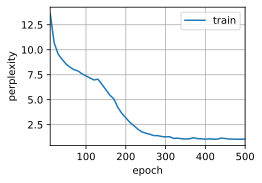

In [13]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果

困惑度 1.5, 62415.2 词元/秒 cuda:0
time travellerit s against reason said the psychologist thoughit
travellerit s against reason said the psychologist thoughit


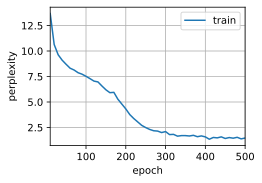

In [14]:
'''
len(vocab)：词表大小（如28个字符），确定输入/输出维度
num_hiddens：隐藏层维度（如256或512），控制模型容量
d2l.try_gpu()：尝试使用GPU加速
get_params：参数初始化函数指针
init_rnn_state：状态初始化函数指针
rnn：前向传播函数指针
'''
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
'''
net：要训练的网络实例
train_iter：数据迭代器（批量生成输入-目标序列）
vocab：词表对象，用于生成文本时的索引↔字符转换
lr：学习率（如0.1或1.0），控制参数更新步长
num_epochs：训练轮数（如500）
d2l.try_gpu() `：训练设备
use_random_iter=True：使用随机采样策略（而非顺序采样）
'''
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)